# 7. Customer churn classifier

In [1]:
%%capture
!pip install catboost
!pip install xgboost

#### Import needed packages

In [2]:
import os
import base64
from dataclasses import field, dataclass
from typing import Callable, List, Tuple
from pathlib import Path
import itertools

from functions.saving_functions import read_file
from functions.preprocessing import transform_features

import numpy as np

# Importing YData's packages
from ydata.labs.datasources import DataSources
from ydata.metadata import Metadata
from ydata.dataset import Dataset
from ydata.utils.data_types import DataType

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score, confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

INFO: 2022-12-04 07:54:37,735 generated new fontManager


#### Auxiliary functions

In [3]:
def validate_models(models:list, X_test, y_test):
    results_df = []
    for k, model in models.items():
        y_pred=models[k].predict(X_test)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        f1 = f1_score(y_test, y_pred)
        cnf_matrix=confusion_matrix(y_test, y_pred)
        precision=precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        tn, fp, fn, tp = cnf_matrix.ravel()

        results_df.append({'model': k, 'rocauc': roc_auc, 'f1': f1, 'precision': precision, 'recall': recall})

    results_df = pd.DataFrame(results_df)
    
    return results_df

In [4]:
def plot_confusion_matrix(cnf_matrix, group_names=["True Neg","False Pos","False Neg","True Pos"]):
    group_names = group_names
    group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    
    return sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

In [5]:
metric_colors = ["#0047AB", "#6495ED", "#bcd3eb", "#7393B3"]

sel_models = [  
               RandomForestClassifier(random_state = 42),
               GradientBoostingClassifier(random_state = 42),
               LGBMClassifier(random_state = 42),
               XGBClassifier(random_state = 42),
               DecisionTreeClassifier(random_state = 42)
            ]

#### Get environment variables

In [6]:
target_col = os.environ.get('TARGET_COL', 'Churn')

## Read the dataset & Metadata

In [7]:
# read the inputs
metadata = read_file('metadata_train.pkl')
dataset = read_file('train_set.pkl')

In [8]:
dataset.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn,CLTV,Avg Montly charges per city,Avg Total charges per city
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2701,62.42377,2130.760691
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,5372,62.42377,2130.760691
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,5340,62.42377,2130.760691
6,Male,Yes,No,No,1,No,No phone service,DSL,No,No,...,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,1,5433,62.42377,2130.760691
7,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,...,No internet service,Month-to-month,No,Mailed check,20.15,20.15,1,4832,62.42377,2130.760691


In [9]:
df = dataset.to_pandas()

y = df[target_col]
X = df.drop(target_col, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

### Data preparation to run the classifier (encoding, etc)

In [10]:
#Muda para receber apenas as colunas do X
X_metadata = metadata[list(set(X.columns)-set([target_col]))]
pX_train, transformer = transform_features(X_train, X_metadata)

### Train classifiers

In [11]:
models = {}
for model in sel_models:
    models[type(model).__name__]=model.fit(pX_train, y_train)
    
models

{'RandomForestClassifier': RandomForestClassifier(random_state=42),
 'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
 'LGBMClassifier': LGBMClassifier(random_state=42),
 'XGBClassifier': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_stat

## Holdout prediction
This should be split into another step

In [12]:
holdout  = read_file('holdout_set.pkl')
holdout_metadata = Metadata.load('metadata_holdout.pkl')

In [13]:
test = holdout.to_pandas()
y_holdout = test[target_col]
X_holdout = test.drop(target_col, axis=1)

pX_holdout = transformer.transform(X_holdout)

In [14]:
holdout_labels = dict(y_holdout.value_counts())

In [15]:
pX_test = transformer.transform(X_test)

In [16]:
results_df = validate_models(models, pX_test, y_test)

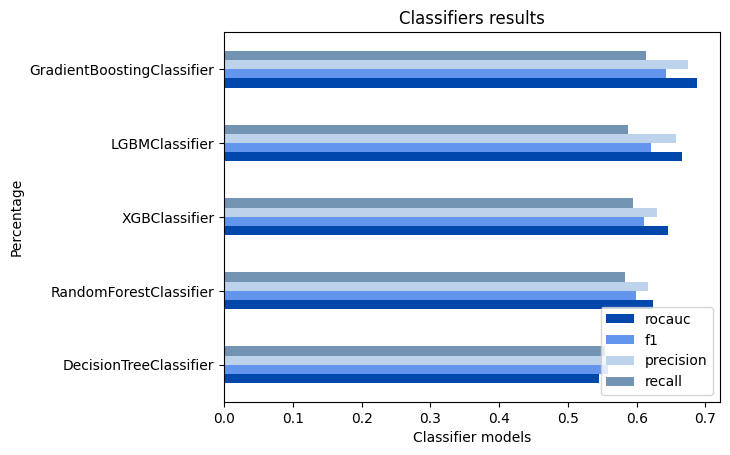

In [17]:
ax = results_df.sort_values('f1').plot.barh(x="model", color=metric_colors, title='Classifiers results')
ax.set_xlabel("Classifier models")
ax.set_ylabel("Percentage")
#Ok configure this plot to be used

plt.savefig('models_metrics.png')

metrics_graph = open('models_metrics.png', 'rb').read() # read bytes from file
metrics_graph = base64.b64encode(metrics_graph)  # encode to base64 (bytes)
metrics_graph = metrics_graph.decode()

In [18]:
best_results_test = dict(results_df.loc[results_df['f1'].idxmax()])

In [19]:
best_model = models[best_results_test['model']]

### Calculating Holdout metrics

In [20]:
holdout_pred = best_model.predict(pX_holdout)

roc_auc = roc_auc_score(y_holdout, best_model.predict_proba(pX_holdout)[:,1])
f1 = f1_score(y_holdout, holdout_pred)
cnf_matrix=confusion_matrix(y_holdout, holdout_pred)
precision=precision_score(y_holdout, holdout_pred)
recall = recall_score(y_holdout, holdout_pred)
cnf_matrix = confusion_matrix(y_holdout, holdout_pred)

metrics = {"rocauc": roc_auc,
           "f1": f1,
           "precision":precision,
           "recall": recall}

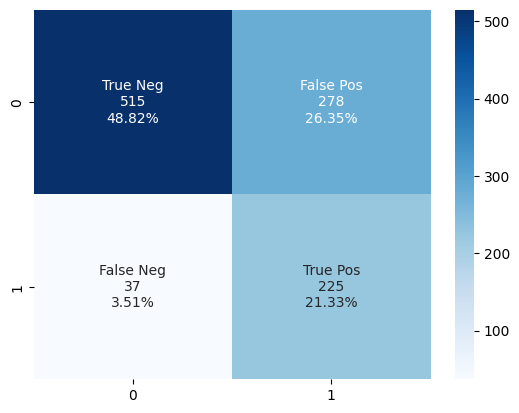

In [21]:
heamap_ax = plot_confusion_matrix(cnf_matrix)

plt.savefig('heatmap_confusion_matrix.png')

matrix_graph = open('heatmap_confusion_matrix.png', 'rb').read() # read bytes from file
matrix_graph = base64.b64encode(matrix_graph)  # encode to base64 (bytes)
matrix_graph = matrix_graph.decode()

In [23]:
# generating the html to visualise in the pipeline!

html_metrics = f"""
<body>
<h2>Model Performance</h2>
<p style="text-align:center;"><img src="data:image/png;base64,{metrics_graph}"></p>
</body>
"""



html_matrix = f"""
<body>
<h2>Confusion Matrix</h2>
<p style="text-align:center;"><img src="data:image/png;base64,{matrix_graph}"></p>
</body>
"""

## Pipelines output

In [24]:
pipeline_parameters = read_file('pipeline_parameters.pkl')

In [25]:
pipeline_parameters= read_file('pipeline_parameters.pkl')

try:
    augment = int(pipeline_parameters['augment'])
except:
    print(pipeline_parameters)
    
sample_size=int(pipeline_parameters['sample_size'])

In [27]:
import json

profile_pipeline_output = {
    'outputs' : [
        {
      'type': 'web-app',
      'storage': 'inline',
      'source': html_metrics,
    },
    {
      'type': 'web-app',
      'storage': 'inline',
      'source': html_matrix,
    },
    ]
  }

with open('mlpipeline-ui-metadata.json', 'w') as metadata_file:
    json.dump(profile_pipeline_output, metadata_file)

In [28]:
metrics = {
'metrics': [
    {
        'name': 'roc-auc-score',
        'numberValue':  metrics["rocauc"],
        'format': 'PERCENTAGE'       
    },
    {
        'name': 'f1-score',
        'numberValue':  metrics["f1"],
        'format': 'PERCENTAGE'  
    },
    {
        'name': 'precision',
        'numberValue':  metrics["precision"],
        'format': 'PERCENTAGE'  
    },
    {
        'name': 'recall',
        'numberValue':  metrics["recall"],
        'format': 'PERCENTAGE'  
    },
    {
        'name': 'y-augment',
        'numberValue':  augment,
        'format': 'RAW'  
    },
    {
        'name': 'y-sample-size',
        'numberValue':  sample_size,
        'format': 'RAW' 
    }
]
}
with open('mlpipeline-metrics.json', 'w') as f:
    json.dump(metrics, f)